# EV Fleet Consumption Prediction Model

This notebook develops and analyzes consumption prediction models for electric vehicles based on:
- Trip characteristics (distance, time, speed)
- Weather conditions (temperature, wind, rain)
- Vehicle specifications (model, battery capacity)
- Driver behavior patterns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our custom consumption model
from consumption_model import EVConsumptionPredictor

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Exploration

In [2]:
# Initialize the predictor
predictor = EVConsumptionPredictor()

# Load the data
print("Loading synthetic EV fleet data...")
data = predictor.load_data()

print(f"Dataset shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")
print(f"Number of vehicles: {data['vehicle_id'].nunique()}")
print(f"Number of trips: {len(data)}")

INFO:consumption_model:Loaded 7690 records for training


Loading synthetic EV fleet data...
Dataset shape: (7690, 35)
Date range: 2024-01-01 to 2024-01-31
Number of vehicles: 20
Number of trips: 7690


In [3]:
# Basic statistics
print("Basic consumption statistics:")
consumption_stats = data['total_consumption_kwh'].describe()
print(consumption_stats)

# Display sample data
print("\nSample of the data:")
display(data.head())

Basic consumption statistics:
count    7690.000000
mean        7.539454
std         7.952012
min         0.001000
25%         0.057000
50%         4.537500
75%        15.078500
max        33.784000
Name: total_consumption_kwh, dtype: float64

Sample of the data:


,vehicle_id,trip_id,date,origin_lat,origin_lon,destination_lat,destination_lon,total_distance_km,total_time_minutes,driver_profile,...,weather_season,model,battery_capacity,efficiency,driving_style,temperature,is_raining,wind_speed_kmh,humidity,season
0,EV_000,EV_000_20240101_00,2024-01-01,37.296317,-121.935524,37.296317,-121.935524,0.0,0.0,commuter,...,winter,nissan_leaf,62.0,16.644372,normal,9.8,False,15.8,0.706955,winter
1,EV_000,EV_000_20240101_01,2024-01-01,37.296317,-121.935524,37.296317,-121.935524,0.0,0.0,commuter,...,winter,nissan_leaf,62.0,16.644372,normal,9.8,False,15.8,0.706955,winter
2,EV_001,EV_001_20240101_00,2024-01-01,37.757378,-122.431095,37.757378,-122.431095,0.0,0.0,commuter,...,winter,tesla_model_3,75.0,16.652047,normal,9.8,False,15.8,0.706955,winter
3,EV_001,EV_001_20240101_01,2024-01-01,37.757378,-122.431095,37.757378,-122.431095,0.0,0.0,commuter,...,winter,tesla_model_3,75.0,16.652047,normal,9.8,False,15.8,0.706955,winter
4,EV_002,EV_002_20240101_00,2024-01-01,37.751183,-122.384048,37.751183,-122.384048,0.0,0.0,casual,...,winter,tesla_model_y,75.0,13.430808,eco_friendly,9.8,False,15.8,0.706955,winter


## 2. Data Visualization and Analysis

ValueError: Wedge sizes 'x' must be non negative values

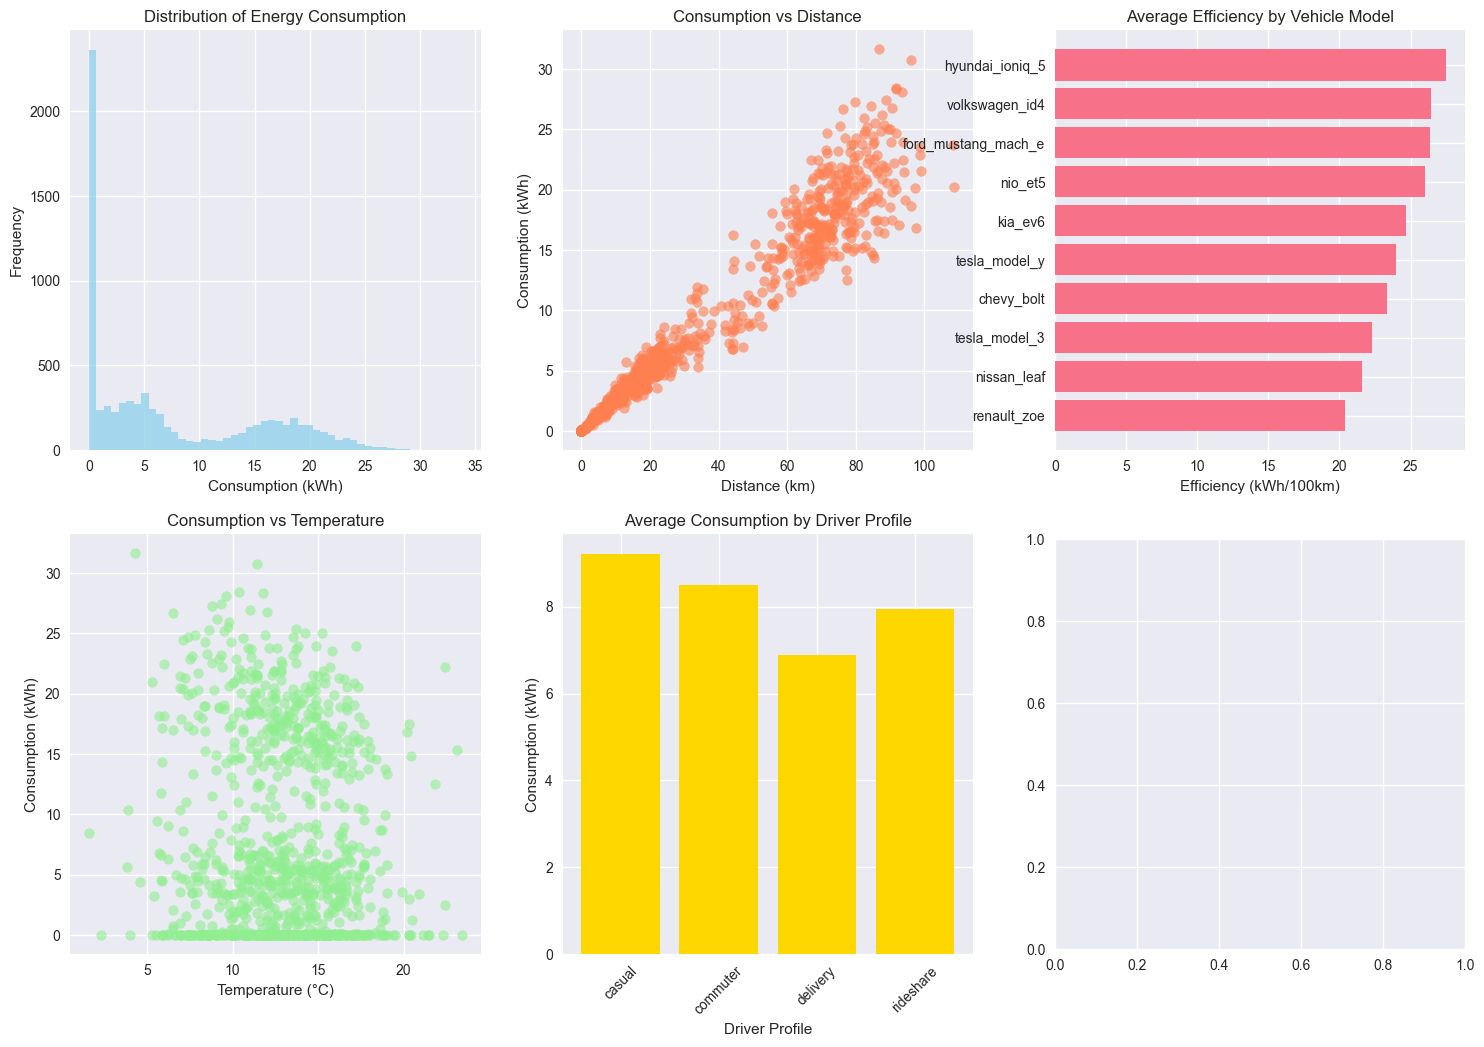

In [4]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Consumption distribution
axes[0, 0].hist(data['total_consumption_kwh'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Energy Consumption')
axes[0, 0].set_xlabel('Consumption (kWh)')
axes[0, 0].set_ylabel('Frequency')

# 2. Consumption vs Distance
sample_data = data.sample(n=min(1000, len(data)), random_state=42)
axes[0, 1].scatter(sample_data['total_distance_km'], sample_data['total_consumption_kwh'], 
                   alpha=0.6, color='coral')
axes[0, 1].set_title('Consumption vs Distance')
axes[0, 1].set_xlabel('Distance (km)')
axes[0, 1].set_ylabel('Consumption (kWh)')

# 3. Efficiency by vehicle model
efficiency_by_model = data.groupby('model')['efficiency_kwh_per_100km'].mean().sort_values()
axes[0, 2].barh(range(len(efficiency_by_model)), efficiency_by_model.values)
axes[0, 2].set_yticks(range(len(efficiency_by_model)))
axes[0, 2].set_yticklabels(efficiency_by_model.index)
axes[0, 2].set_title('Average Efficiency by Vehicle Model')
axes[0, 2].set_xlabel('Efficiency (kWh/100km)')

# 4. Consumption vs Temperature
axes[1, 0].scatter(sample_data['temperature_celsius'], sample_data['total_consumption_kwh'], 
                   alpha=0.6, color='lightgreen')
axes[1, 0].set_title('Consumption vs Temperature')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Consumption (kWh)')

# 5. Consumption by driver profile
consumption_by_driver = data.groupby('driver_profile')['total_consumption_kwh'].mean()
axes[1, 1].bar(consumption_by_driver.index, consumption_by_driver.values, color='gold')
axes[1, 1].set_title('Average Consumption by Driver Profile')
axes[1, 1].set_xlabel('Driver Profile')
axes[1, 1].set_ylabel('Consumption (kWh)')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Consumption components breakdown
consumption_components = [
    'consumption_rolling_resistance_kwh',
    'consumption_aerodynamic_drag_kwh',
    'consumption_elevation_change_kwh',
    'consumption_acceleration_kwh',
    'consumption_hvac_kwh',
    'consumption_auxiliary_kwh'
]

component_means = [data[col].mean() for col in consumption_components]
component_labels = [col.replace('consumption_', '').replace('_kwh', '') for col in consumption_components]

axes[1, 2].pie(component_means, labels=component_labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Average Consumption Breakdown')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [5]:
# Apply feature engineering
print("Engineering features...")
data_engineered = predictor.engineer_features(data)

print(f"Original features: {data.shape[1]}")
print(f"Features after engineering: {data_engineered.shape[1]}")

# Show new features
new_features = set(data_engineered.columns) - set(data.columns)
print(f"\nNew features created: {list(new_features)}")

Engineering features...
Original features: 48
Features after engineering: 48

New features created: []


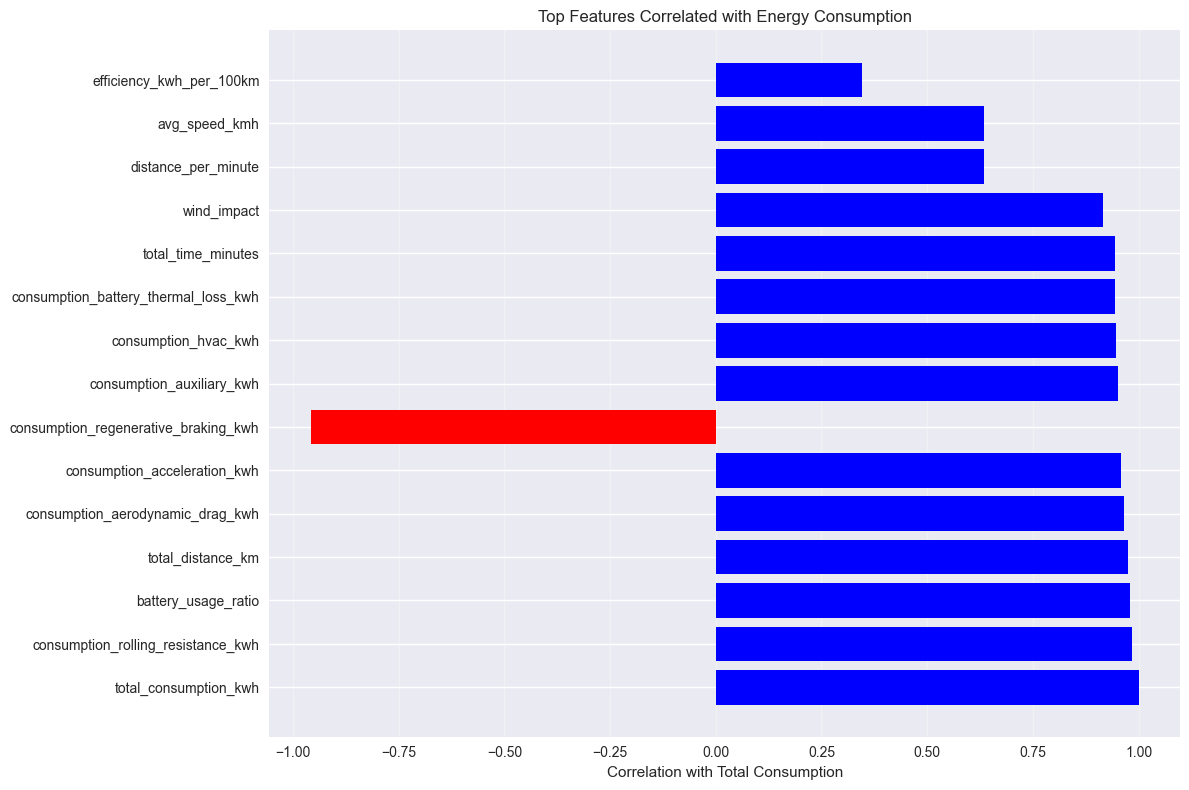

Top 10 features correlated with consumption:
total_consumption_kwh: 1.000
consumption_rolling_resistance_kwh: 0.984
battery_usage_ratio: 0.979
total_distance_km: 0.975
consumption_aerodynamic_drag_kwh: 0.966
consumption_acceleration_kwh: 0.959
consumption_regenerative_braking_kwh: -0.958
consumption_auxiliary_kwh: 0.952
consumption_hvac_kwh: 0.947
consumption_battery_thermal_loss_kwh: 0.945


In [6]:
# Correlation analysis
# Select numeric columns for correlation
numeric_cols = data_engineered.select_dtypes(include=[np.number]).columns
correlation_with_consumption = data_engineered[numeric_cols].corr()['total_consumption_kwh'].sort_values(key=abs, ascending=False)

# Plot top correlations
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_consumption.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlation with Total Consumption')
plt.title('Top Features Correlated with Energy Consumption')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 10 features correlated with consumption:")
for feature, corr in top_correlations.head(10).items():
    print(f"{feature}: {corr:.3f}")

## 4. Model Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare features and target
print("Preparing features and target variable...")
X, y = predictor.prepare_features(data_engineered)

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {list(X.columns)}")

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

In [ ]:
# Train multiple models
print("Training models...")
predictor.train_models(X_train, y_train, X_val, y_val)

# Display model performance
performance_df = pd.DataFrame(predictor.model_performance).T
print("\nModel Performance Comparison:")
display(performance_df.round(4))

In [ ]:
# Visualize model performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance metrics comparison
metrics = ['MAE', 'RMSE', 'R2']
models = list(predictor.model_performance.keys())

x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics):
    values = [predictor.model_performance[model][metric] for model in models]
    axes[0].bar(x + i*width, values, width, label=metric)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Metric Value')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Best model predictions vs actual
best_model = predictor.get_best_model()
val_predictions = predictor.predict(X_val, best_model)

axes[1].scatter(y_val, val_predictions, alpha=0.6, color='purple')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Consumption (kWh)')
axes[1].set_ylabel('Predicted Consumption (kWh)')
axes[1].set_title(f'Predictions vs Actual ({best_model})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best model: {best_model}")

## 5. Feature Importance Analysis

In [ ]:
# Feature importance for tree-based models
if predictor.feature_importance:
    importance_df = predictor.get_feature_importance_summary()
    
    # Plot feature importance for each model
    tree_models = [model for model in predictor.feature_importance.keys()]
    
    fig, axes = plt.subplots(1, len(tree_models), figsize=(15, 6))
    if len(tree_models) == 1:
        axes = [axes]
    
    for i, model in enumerate(tree_models):
        model_importance = importance_df[importance_df['model'] == model].sort_values('importance', ascending=True)
        top_features = model_importance.tail(10)
        
        axes[i].barh(range(len(top_features)), top_features['importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'])
        axes[i].set_title(f'Top 10 Features - {model}')
        axes[i].set_xlabel('Importance')
        axes[i].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display top features
    best_model_importance = importance_df[importance_df['model'] == best_model].sort_values('importance', ascending=False)
    print(f"\nTop 10 most important features for {best_model}:")
    for _, row in best_model_importance.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
else:
    print("Feature importance not available for the selected models.")

## 6. Model Testing and Final Evaluation

In [ ]:
# Test the best model on the test set
test_predictions = predictor.predict(X_test, best_model)

# Calculate final test metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print(f"Final Test Results for {best_model}:")
print(f"MAE: {test_mae:.4f} kWh")
print(f"RMSE: {test_rmse:.4f} kWh")
print(f"R²: {test_r2:.4f}")
print(f"Mean consumption: {y_test.mean():.4f} kWh")
print(f"MAPE: {np.mean(np.abs((y_test - test_predictions) / y_test)) * 100:.2f}%")

In [ ]:
# Prediction error analysis
prediction_errors = test_predictions - y_test

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Error distribution
axes[0, 0].hist(prediction_errors, bins=50, alpha=0.7, color='lightcoral')
axes[0, 0].set_title('Distribution of Prediction Errors')
axes[0, 0].set_xlabel('Prediction Error (kWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0, color='red', linestyle='--', alpha=0.8)

# Residuals vs predicted
axes[0, 1].scatter(test_predictions, prediction_errors, alpha=0.6, color='lightblue')
axes[0, 1].set_title('Residuals vs Predicted Values')
axes[0, 1].set_xlabel('Predicted Consumption (kWh)')
axes[0, 1].set_ylabel('Prediction Error (kWh)')
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.8)
axes[0, 1].grid(alpha=0.3)

# Actual vs predicted scatter
axes[1, 0].scatter(y_test, test_predictions, alpha=0.6, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_title('Actual vs Predicted Consumption')
axes[1, 0].set_xlabel('Actual Consumption (kWh)')
axes[1, 0].set_ylabel('Predicted Consumption (kWh)')
axes[1, 0].grid(alpha=0.3)

# Q-Q plot for error normality
from scipy import stats
stats.probplot(prediction_errors, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Prediction Errors')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Practical Predictions and Use Cases

In [ ]:
# Example predictions for different scenarios
print("Example consumption predictions for various trip scenarios:\n")

scenarios = [
    {
        'name': 'Short city commute',
        'distance_km': 15,
        'time_minutes': 30,
        'temperature': 20,
        'vehicle_model': 'tesla_model_3',
        'driver_profile': 'commuter'
    },
    {
        'name': 'Highway trip',
        'distance_km': 100,
        'time_minutes': 80,
        'temperature': 25,
        'vehicle_model': 'tesla_model_y',
        'driver_profile': 'casual',
        'wind_speed': 20
    },
    {
        'name': 'Cold weather trip',
        'distance_km': 50,
        'time_minutes': 60,
        'temperature': -5,
        'vehicle_model': 'nissan_leaf',
        'driver_profile': 'commuter',
        'season': 'winter'
    },
    {
        'name': 'Hot summer drive',
        'distance_km': 75,
        'time_minutes': 90,
        'temperature': 35,
        'vehicle_model': 'tesla_model_3',
        'driver_profile': 'casual',
        'season': 'summer'
    }
]

results = []
for scenario in scenarios:
    name = scenario.pop('name')
    prediction = predictor.predict_trip_consumption(**scenario)
    results.append({
        'Scenario': name,
        'Distance (km)': scenario['distance_km'],
        'Predicted Consumption (kWh)': f"{prediction['predicted_consumption_kwh']:.2f}",
        'Efficiency (kWh/100km)': f"{prediction['efficiency_kwh_per_100km']:.2f}",
        'Vehicle': scenario['vehicle_model'],
        'Temperature (°C)': scenario['temperature']
    })

results_df = pd.DataFrame(results)
display(results_df)

In [ ]:
# Interactive prediction function
def predict_consumption_interactive(distance=50, time=60, temperature=20, 
                                   vehicle='tesla_model_3', driver='commuter'):
    """
    Interactive function for consumption prediction
    """
    prediction = predictor.predict_trip_consumption(
        distance_km=distance,
        time_minutes=time,
        temperature=temperature,
        vehicle_model=vehicle,
        driver_profile=driver
    )
    
    print(f"Trip Details:")
    print(f"- Distance: {distance} km")
    print(f"- Time: {time} minutes")
    print(f"- Average speed: {distance/(time/60):.1f} km/h")
    print(f"- Temperature: {temperature}°C")
    print(f"- Vehicle: {vehicle}")
    print(f"- Driver profile: {driver}")
    print(f"\nPrediction:")
    print(f"- Energy consumption: {prediction['predicted_consumption_kwh']:.2f} kWh")
    print(f"- Efficiency: {prediction['efficiency_kwh_per_100km']:.2f} kWh/100km")
    print(f"- Model used: {prediction['model_used']}")
    
    return prediction

# Example usage
print("Example prediction:")
example_result = predict_consumption_interactive(distance=80, time=75, temperature=15)

## 8. Model Saving and Summary

In [ ]:
# Save the trained model
model_path = Path.cwd() / "consumption_model.pkl"
predictor.save_model(model_path)

print(f"Model saved to: {model_path}")
print(f"\nModel Summary:")
print(f"- Best performing model: {predictor.get_best_model()}")
print(f"- Training data: {len(X_train) + len(X_val)} samples")
print(f"- Test accuracy (R²): {test_r2:.4f}")
print(f"- Test RMSE: {test_rmse:.4f} kWh")
print(f"- Features used: {len(X.columns)}")

print("\nThe model can predict EV energy consumption based on:")
print("✓ Trip characteristics (distance, time, speed)")
print("✓ Weather conditions (temperature, wind, rain)")
print("✓ Vehicle specifications (model, battery capacity)")
print("✓ Driver behavior patterns")
print("✓ Temporal factors (time of day, season)")